# Review Sentiment Analysis

In this project, I have tried to create a sentiment analysis algorithm based on restaurant review data scrapped from google reviews for cafes, restaurants and eateries based out of Bengaluru. After data collection, basic information gathering is done and data is processed a bit before going onto cleaning stage. NLP pipeline is created where reviews are cleaned and then model is fit to the final data.<br>
<br>
<b> Business Understanding:</b>
The main aim of the project is to create a sentiment analysis model that is localized to Indian reviews since people here have different ways of expressing their emotions and using some localized words and expressions.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords

Installing required libraries

In [2]:
!pip install emot # for handling emojis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 5.8 MB/s eta 0:00:00


In [3]:
!pip install contractions #for handling contractions like won't --> will not

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.8 MB/s eta 0:00:00


In [4]:
!pip install lemminflect # lemmatization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 29.9 MB/s eta 0:00:00


In [5]:
!pip install symspellpy # for spelling corrections

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl size=141745 sha256=1b526f3862055057c473b6468cec1a7aed46af2c1ea6129c5864a61b8345abdd
  Stored in directory: /root/.cache/pip/wheels/88/6a/a6/a1283cc145323a1fb3d475bd158ee60b248ab1985230d266fc
Successfully built editdistpy


In [6]:
import re
import pickle
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO # for emojis and emoticons both

## Importing the data

In [7]:
data=pd.read_excel("Final Data.xlsx")

In [8]:
df1 = pd.DataFrame(data)

In [9]:
df1.drop(columns=['Name','Date','Rating'],axis=1,inplace=True)

In [10]:
df1

,Stars,Content
0,5,Great experience at this Fruitbae.\nLocation i...
1,4,Visited late night to have a snack and an ice ...
2,5,Yummiest desserts.😍 best place for all the ice...
3,3,Dry nut falooda was really good. Fruit pafe wa...
4,1,It took more than one and half hour to get you...
...,...,...
25985,3,NaN
25986,5,NaN
25987,3,NaN
25988,5,NaN


## Data Exploration

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25990 entries, 0 to 25989
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Stars    25990 non-null  int64 
 1   Content  21461 non-null  object
dtypes: int64(1), object(1)
memory usage: 406.2+ KB


In [12]:
df1.isnull().sum()

Stars         0
Content    4529
dtype: int64

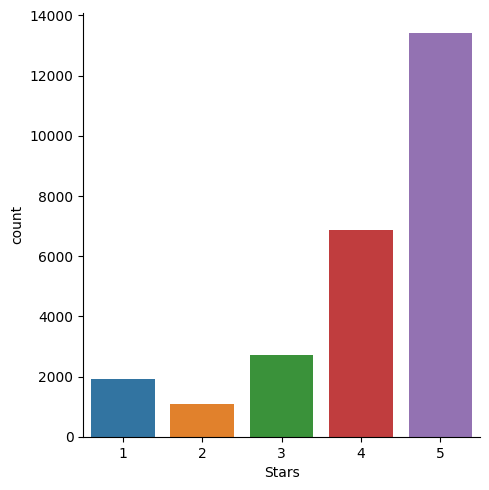

In [13]:
sns.catplot(data=df1,x='Stars',kind='count')

We see that the data is imbalanced as category 4,5 has more data 

In [14]:
df1.dropna(axis=0,inplace=True) # removing null values

In [15]:
df1.isnull().sum()

Stars      0
Content    0
dtype: int64

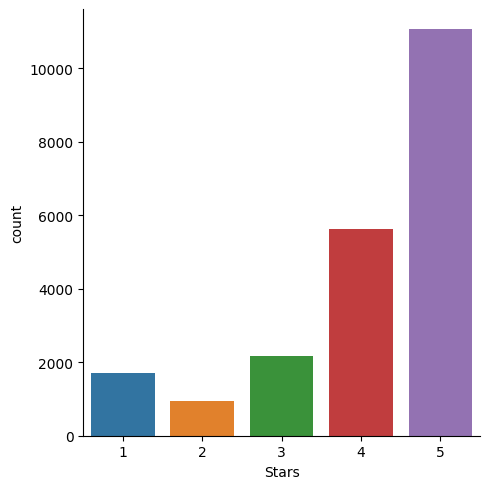

In [16]:
sns.catplot(data=df1,x='Stars',kind='count')

In [17]:
df1['Stars'].value_counts() #distribtuion of reviews in different star category

5    11052
4     5618
3     2157
1     1700
2      934
Name: Stars, dtype: int64

In [18]:
df1.reset_index(inplace=True)

In [19]:
df1.drop(columns=['index'],inplace=True)

In [20]:
def strip_newline(my_str):  # for removing unnecessary newline character and adjust all reviews in one line
  result = " ".join(line.strip() for line in my_str.splitlines())
  return result

In [21]:
for i in range(len(df1['Content'])):
  df1.iloc[i,1] = strip_newline(df1['Content'][i])

In [22]:
def map_sentiment(stars_received):  # to assign sentiment score as: 1 -- 4,5 Star :: 0 -- 3 Star :: -1 -- 1,2 Star
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1
# Mapping stars to sentiment into three categories
df1['Sentiment'] = [ map_sentiment(x) for x in df1['Stars']]

In [23]:
df1

,Stars,Content,Sentiment
0,5,Great experience at this Fruitbae. Location is...,1
1,4,Visited late night to have a snack and an ice ...,1
2,5,Yummiest desserts.😍 best place for all the ice...,1
3,3,Dry nut falooda was really good. Fruit pafe wa...,0
4,1,It took more than one and half hour to get you...,-1
...,...,...,...
21456,5,Taste is great~,1
21457,4,clean and delicious,1
21458,2,Channgi here,-1
21459,5,After all Japanese food,1


In [24]:
df1['Sentiment'].value_counts()

 1    16670
-1     2634
 0     2157
Name: Sentiment, dtype: int64

Now we try to create a balanced data by keeping equal amount of reviews in each category (approx 2500)

In [25]:
positive_rev=[]
negative_rev=[]
neutral_rev=[]

for i in range(len(df1)):
  if len(positive_rev)<3000:
    if df1['Sentiment'][i] == 1:
      positive_rev.append(df1['Content'][i])
  else:
    break

for j in range(len(df1)):
  if df1['Sentiment'][j] == -1:
    negative_rev.append(df1['Content'][j])
  elif df1['Sentiment'][j] == 0:
    neutral_rev.append(df1['Content'][j])


In [26]:
positive_df = pd.DataFrame(positive_rev,columns=['Review'])
positive_df['Sentiment'] = 1

negative_df = pd.DataFrame(negative_rev,columns=['Review'])
negative_df['Sentiment'] = -1

neutral_df = pd.DataFrame(neutral_rev,columns=['Review'])
neutral_df['Sentiment'] = 0

In [27]:
final_df = pd.concat([positive_df,neutral_df,negative_df],axis=0)
final_df

,Review,Sentiment
0,Great experience at this Fruitbae. Location is...,1
1,Visited late night to have a snack and an ice ...,1
2,Yummiest desserts.😍 best place for all the ice...,1
3,Really got addicted to these desserts. So ligh...,1
4,Good to try faloodas. Take signature one 2 peo...,1
...,...,...
2629,Good sarvice,-1
2630,"Good place for sushi and sashimi. Also, not ve...",-1
2631,"I stopped by for lunch, but unfortunately it w...",-1
2632,koi galti se bhi Jana mat kacchi machhi khila ...,-1


In [28]:
final_df.reset_index(inplace=True)
final_df.drop(columns=['index'],inplace=True)
final_df

,Review,Sentiment
0,Great experience at this Fruitbae. Location is...,1
1,Visited late night to have a snack and an ice ...,1
2,Yummiest desserts.😍 best place for all the ice...,1
3,Really got addicted to these desserts. So ligh...,1
4,Good to try faloodas. Take signature one 2 peo...,1
...,...,...
7786,Good sarvice,-1
7787,"Good place for sushi and sashimi. Also, not ve...",-1
7788,"I stopped by for lunch, but unfortunately it w...",-1
7789,koi galti se bhi Jana mat kacchi machhi khila ...,-1


Now we have a balanced review dataframe and create a NLP pipeline for data cleaning.

### NLP Pipeline

In [29]:
from tqdm import tqdm

In [30]:
import contractions  #expanding words like shalln't, shouldn't etc.

def contraction_(line):
    return contractions.fix(line)
    

In [31]:
from bs4 import BeautifulSoup
cleanr = re.compile('<.*?>')
def remove_tags(line1): #function to clean words of any html tags
    
    cleantext = re.sub(cleanr,' ',line1)
    return cleantext

In [32]:
import re

def remove_urls(vTEXT):  # removing valid urls
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%|\-)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT.strip()) 

In [33]:
def cleanpunc(sentence): # clearing punctuation marks
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/)]',r'',cleaned)
    return cleaned

In [34]:
import nltk
nltk.download('stopwords')
stop = stopwords.words('english') # set of stopwords
stop.remove('nor')
stop.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
stopwords1= set(['the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [36]:
final_stopwords = stopwords1.union(stop) #final set of stopwords

In [37]:
def convert_emojis(text): # handling emojis
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text
with open("Emoticon_Dict.p", 'rb') as fp:
      Emoticon_Dict = pickle.load(fp)


def convert_emoticons(text): # handling emoticons
    
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    text_temp = emoticon_pattern.sub(r'', text)
    return text_temp

In [38]:
from symspellpy import SymSpell 
symsp = SymSpell()
symsp.load_dictionary('freq_dict.txt',term_index=0,count_index=1,separator=' ',encoding='utf8')
def spell_check(sentence): # correcting spelling mistakes
  terms = symsp.lookup_compound(sentence,max_edit_distance=2) 
  return terms[0].term

In [39]:
import lemminflect
import spacy
nlp = spacy.load('en_core_web_sm',disable=['praser', 'ner'])
nlp.add_pipe('sentencizer')

def lemma(word):  # lemmatizing the words
    
    doc = nlp(word)
    for item in doc:
         return item._.lemma()


In [43]:
final_string = []
all_positive_words=[]
all_negative_words=[]
  
def cleaner_nlp(): # final pipeline of nlp
  i=0
  str1=''
  s=''
  for sent in tqdm(df1['Content'].values):
    filtered_sentence=[]
    
    sent = remove_urls(sent)
    sent = remove_tags(sent)
    sent = convert_emojis(sent)
    sent = convert_emoticons(sent)
    sent = spell_check(sent)
    sent = contraction_(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) and (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in final_stopwords):
                    
                    s=(lemma(cleaned_words.lower()))
                    filtered_sentence.append(s)
                    if(df1['Stars'].values)[i] == 'Positive':
                        all_positive_words.append(s)
                    if(df1['Stars'].values)[i] == 'Negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    
    str1 = " ".join(filtered_sentence) #final string of cleaned words

    final_string.append(str1)
    i+=1
                

In [44]:
cleaner_nlp()

100%|██████████| 21461/21461 [24:52<00:00, 14.38it/s]


In [42]:
final_df['Processed'] = final_string # dataframe of balanced review

In [45]:
df1['Processed'] = final_string # full review processed dataframe

## Feature Engineering

###### Training  TF-IDF and TF-IDF Weighted Word2Vec 

Tokenizing the Sentence

In [87]:
from nltk.tokenize import RegexpTokenizer
review_data_list = list()

indv_lines = list(df1['Processed'].values)
for line in indv_lines: # for tokenizing the sentences into words
  rem_tok_punc = RegexpTokenizer(r'\w+')
  tokens = rem_tok_punc.tokenize(line)
  words = [w for w in tokens]
  review_data_list.append(words)

len(review_data_list)

21461

Word2Vec Model

In [88]:
from gensim.models import Word2Vec
import time
# Skip-gram model (sg = 1)
size = 300
window = 3
min_count = 1
workers = 10
ep = 10
sg = 1

word2vec_model_file = 'word2vec_' + str(size) + '.model'
start_time = time.time()

# Train the Word2Vec Model

w2v_model = Word2Vec(review_data_list, vector_size=size, window=window, min_count=min_count, workers=workers, epochs=ep, sg=1)
print("Time taken to train word2vec model: " + str(time.time() - start_time))

w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 16.11370849609375


In [89]:
print(len(list(w2v_model.wv.key_to_index)))

8319


In [90]:
w2v_words = list(w2v_model.wv.index_to_key)
print("number of words that occured minimum 1 time= ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 1 time=  8319
sample words  ['good', 'food', 'place', 'not', 'taste', 'dose', 'try', 'service', 'great', 'visit', 'one', 'nice', 'also', 'must', 'price', 'get', 'ambience', 'time', 'like', 'well', 'bangalore', 'love', 'tasty', 'serve', 'marsala', 'really', 'order', 'restaurant', 'amazing', 'crowd', 'face', 'quality', 'staff', 'eat', 'awesome', 'chutney', 'idle', 'coffee', 'make', 'indian', 'worth', 'experience', 'dish', 'wait', 'take', 'idly', 'bad', 'delicious', 'item', 'egg']


Splitting the data into training and testing

In [91]:
from sklearn.model_selection import train_test_split
x = df1['Processed']
y = df1['Sentiment']
x_train, x_test,y_train, y_test = train_test_split(x, y,random_state=42,test_size=0.30,shuffle=True)
print(len(x_train),"  ",len(x_test))

15022    6439


TF-IDF Vectorizer

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

model = TfidfVectorizer()
x_train_tf = model.fit_transform(x)
x_train_tf = model.transform(x_train)
x_test_tf = model.transform(x_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))


In [93]:
x_train_tf.shape

(15022, 8318)

In [94]:
x_train_list = []
for a in x_train:
  x_train_list.append(a.split())

x_test_list = []
for b in x_test:
  x_test_list.append(b.split())

TF-IDF Weighted Word2Vec

In [95]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
import numpy as np

tfidf_sent_vectors_x_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_train_list): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_x_train.append(sent_vec)
    row += 1

100%|██████████| 15022/15022 [01:26<00:00, 174.26it/s]


In [96]:
tfidf_sent_vectors_x_test = []; # the tfidf-w2v for each sentence/review is stored in this list

for sent in tqdm(x_test_list): # for each review/sentence
  
  sent_vec = np.zeros(300) # as word vectors are of zero length
  weight_sum =0; # num of words with a valid vector in the sentence/review
  for word in sent: # for each word in a review/sentence
      
      if word in w2v_words and word in tfidf_feat:
          vec = w2v_model.wv[word]
          
          # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
          # to reduce the computation we are using 
          # dictionary[word] = idf value of word in whole courpus
          # sent.count(word) = tf values of word in this review
          tf_idf = dictionary[word]*(sent.count(word)/len(sent))
          sent_vec += (vec * tf_idf)
          weight_sum += tf_idf
  if weight_sum != 0:
      sent_vec /= weight_sum
  tfidf_sent_vectors_x_test.append(sent_vec)
  
    

100%|██████████| 6439/6439 [00:35<00:00, 181.30it/s]


Training tfidf-word2vec Model using Multinomial Naive Bayes

In [97]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
MNB = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
MNB.fit(tfidf_sent_vectors_x_train, y_train) 

# Predicting the Test set results
y_pred_w2v = MNB.predict(tfidf_sent_vectors_x_test)
print(metrics.classification_report(y_test, y_pred_w2v))

              precision    recall  f1-score   support

          -1       0.83      0.02      0.04       798
           0       0.00      0.00      0.00       641
           1       0.78      1.00      0.88      5000

    accuracy                           0.78      6439
   macro avg       0.54      0.34      0.30      6439
weighted avg       0.71      0.78      0.68      6439



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training tf-idf model using Multinomial Naive Bayes

In [98]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(x_train_tf, y_train)

# Predicting the Test set results
y_pred_tfidf = classifier.predict(x_test_tf)

from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_tfidf))


              precision    recall  f1-score   support

          -1       0.91      0.23      0.36       798
           0       0.25      0.00      0.00       641
           1       0.80      1.00      0.89      5000

    accuracy                           0.80      6439
   macro avg       0.65      0.41      0.42      6439
weighted avg       0.76      0.80      0.74      6439



Training tf-idf word2vec using Random Forest Classifier

In [99]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()  
clf.fit(tfidf_sent_vectors_x_train, y_train)
y_pred_rf = clf.predict(tfidf_sent_vectors_x_test)
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

          -1       0.76      0.58      0.66       798
           0       0.38      0.05      0.08       641
           1       0.86      0.98      0.92      5000

    accuracy                           0.84      6439
   macro avg       0.66      0.54      0.55      6439
weighted avg       0.80      0.84      0.80      6439



### Running a Test Case

In [109]:
test_rev = ["food was not that good....won't advice to visit here"]

test_df = pd.DataFrame(test_rev,columns=['Content'])
final_string = []
all_positive_words=[]
all_negative_words=[]
  
def cleaner_nlp_test():
  i=0
  str1=''
  s=''
  for sent in tqdm(test_df['Content']):
    filtered_sentence=[]
    print(sent)
    sent = remove_urls(sent)
    sent = remove_tags(sent)
    sent = convert_emojis(sent)
    sent = convert_emoticons(sent)
    sent = spell_check(sent)
    sent = contraction_(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) and (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in final_stopwords):
                    
                    s=(lemma(cleaned_words.lower()))
                    filtered_sentence.append(s)
                    if(df1['Stars'].values)[i] == 'Positive':
                        all_positive_words.append(s)
                    if(df1['Stars'].values)[i] == 'Negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    
    str1 = " ".join(filtered_sentence) #final string of cleaned words

    final_string.append(str1)
    i+=1

In [110]:
cleaner_nlp_test()

100%|██████████| 1/1 [00:00<00:00, 21.06it/s]

food was not that good....won't advice to visit here


In [111]:
final_string

['food not good not advice visit']

In [112]:
test_rev_tf = model.transform(final_string)

In [113]:
tfidf_sent_vectors_test_rv = []; # the tfidf-w2v for each sentence/review is stored in this list

for sent in tqdm(test_df): # for each review/sentence
  
  sent_vec = np.zeros(300) # as word vectors are of zero length
  weight_sum =0; # num of words with a valid vector in the sentence/review
  for word in sent: # for each word in a review/sentence
      
      if word in w2v_words and word in tfidf_feat:
          vec = w2v_model.wv[word]
          
          # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
          # to reduce the computation we are 
          # dictionary[word] = idf value of word in whole courpus
          # sent.count(word) = tf values of word in this review
          tf_idf = dictionary[word]*(sent.count(word)/len(sent))
          sent_vec += (vec * tf_idf)
          weight_sum += tf_idf
  if weight_sum != 0:
      sent_vec /= weight_sum
  tfidf_sent_vectors_test_rv.append(sent_vec)
  

100%|██████████| 1/1 [00:00<00:00, 47.05it/s]


In [114]:
res=clf.predict(tfidf_sent_vectors_test_rv)[0]
if res==1:
    print("Good Review")    
elif res==0:
    print("Neutral Review")
else:
  print("Bad Review")

Good Review


In [115]:
res=classifier.predict(test_rev_tf)
if res==1:
    print("Good Review")    
elif res==0:
    print("Neutral Review")
else:
  print("Bad Review")

Good Review


In [116]:
res=MNB.predict(tfidf_sent_vectors_test_rv)
if res==1:
    print("Good Review")    
elif res==0:
    print("Neutral Review")
else:
  print("Bad Review")

Good Review


<b>Intermediate Result:</b> We see that tf-idf vector of words give better result when fitted using naive bayes than the other models and vectorization methods. 

Now we try to use LSTM to fit the vectors of reviews and compare the results.

# LSTM

Training a modification of RNN as we know LSTM takes into context the neighbouring words and gives better prediction on tasks like these.

In [46]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [47]:
df1

,Stars,Content,Sentiment,Processed
0,5,Great experience at this Fruitbae. Location is...,1,great experience fruit location easily accessi...
1,4,Visited late night to have a snack and an ice ...,1,visit late night snack ice cream locate heart ...
2,5,Yummiest desserts.😍 best place for all the ice...,1,dummy dessert smile face heart eye good place ...
3,3,Dry nut falooda was really good. Fruit pafe wa...,0,dry nut flood really good fruit page not expec...
4,1,It took more than one and half hour to get you...,-1,take one half hour get order also place order ...
...,...,...,...,...
21456,5,Taste is great~,1,taste great
21457,4,clean and delicious,1,clean delicious
21458,2,Channgi here,-1,change
21459,5,After all Japanese food,1,japanese food


In [48]:
s = 0.0
for i in df1['Processed']:
    word_list = i.split()
    s = s + len(word_list)
print("Average length of each review : ",s/df1.shape[0])

Average length of each review :  16.112063743534783


In [131]:
from sklearn.model_selection import train_test_split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(df1['Processed'], df1['Sentiment'], test_size=0.20, random_state=42)

Tokenizing train and test reviews and converting them to array of digits along with padding.

In [132]:
# Hyperparameters of the model

embedding_dim = 100
max_length = 50  # max review length to cap the reviews to same length
padding_type='post' # to pad the review with zeros after the words of the review

# tokenize sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df1['Processed'])
word_index = tokenizer.word_index
vocab_size = len(word_index)+1
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [133]:
len(word_index) # no of unique words in whole corpus

8319

In [134]:
import keras
from keras.models import Sequential
from keras.layers import Input, CuDNNLSTM, Dense
from keras.layers import Embedding
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
# Since passing output to next LSTM layer set return_sequence to True.
model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(64)))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model summary
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 100)           832000    
                                                                 
 bidirectional_12 (Bidirecti  (None, 50, 128)          84992     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 128)              99328     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,020,481
Trainable params: 1,020,481
No

In [136]:
num_epochs = 7
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/7
483/483 [==============================] - 12s 24ms/step - loss: -6084.8481 - accuracy: 0.8049 - val_loss: -4662.9604 - val_accuracy: 0.7740
Epoch 2/7
483/483 [==============================] - 8s 17ms/step - loss: -7177.5664 - accuracy: 0.8001 - val_loss: -6079.4634 - val_accuracy: 0.7897
Epoch 3/7
483/483 [==============================] - 8s 16ms/step - loss: -9129.7100 - accuracy: 0.8028 - val_loss: -7233.2417 - val_accuracy: 0.7746
Epoch 4/7
483/483 [==============================] - 9s 18ms/step - loss: -10770.7715 - accuracy: 0.8049 - val_loss: -8644.8535 - val_accuracy: 0.7822
Epoch 5/7
483/483 [==============================] - 9s 19ms/step - loss: -12131.2764 - accuracy: 0.8010 - val_loss: -9195.4775 - val_accuracy: 0.7566
Epoch 6/7
483/483 [==============================] - 7s 15ms/step - loss: -14417.1211 - accuracy: 0.8023 - val_loss: -11356.8418 - val_accuracy: 0.7781
Epoch 7/7
483/483 [==============================] - 9s 18ms/step - loss: -16589.6523 - accurac

In [137]:
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", metrics.accuracy_score(test_labels,pred_labels))

135/135 [==============================] - 1s 6ms/step
Accuracy of prediction on test set :  0.7745166550197997


In [141]:
test_seq_rv = ["idli was very amazing quality...will visit again"]
test_seq_df = pd.DataFrame(test_seq_rv,columns=['Content'])
final_string = []
all_positive_words=[]
all_negative_words=[]
  
def cleaner_nlp_test():
  i=0
  str1=''
  s=''
  for sent in tqdm(test_seq_df['Content']):
    filtered_sentence=[]
    print(sent)
    sent = remove_urls(sent)
    sent = remove_tags(sent)
    sent = convert_emojis(sent)
    sent = convert_emoticons(sent)
    sent = spell_check(sent)
    sent = contraction_(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) and (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in final_stopwords):
                    
                    s=(lemma(cleaned_words.lower()))
                    filtered_sentence.append(s)
                    if(df1['Stars'].values)[i] == 'Positive':
                        all_positive_words.append(s)
                    if(df1['Stars'].values)[i] == 'Negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    
    str1 = " ".join(filtered_sentence) #final string of cleaned words

    final_string.append(str1)
    i+=1
cleaner_nlp_test()  

test_sequences = tokenizer.texts_to_sequences(final_string)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

100%|██████████| 1/1 [00:00<00:00, 27.51it/s]

idli was very amazing quality...will visit again


In [143]:
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
  print(i)
  if i >= 0.5:
    pred_labels.append(1)
  else:
    pred_labels.append(0)
print("Review is: ",pred_labels)

1/1 [==============================] - 0s 54ms/step
[0.67387116]
Review is:  [1]


We can see that LSTM is giving better accuracy on the full dataframe than traditional ML Algorithms but still there is a lot of scope of improvement. More data can be collected and balance can be created between all the type of reviews and then LSTM can be fitted since neural networks work better on bigger data size.